# 讲解在 https://zhuanlan.zhihu.com/p/107889011

In [1]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip install numpy matplotlib spacy torchtext seaborn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math,copy,time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk") 
# seaborn只在最后可视化self-attention的时候用到，
# 可以先不管或者注释掉这两行
%matplotlib inline 
# only for jupyter notebook

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 1.Embeddings

顾名思义，Embeddings类主要负责对输入的source sequence和target

sequence的词嵌入表示的映射，具体为每个词从one-hot表示，映射为d_model维度的一个向量。这样的话，如果有10个词，d_model为512的时候，则我们得到的是一个10*512的矩阵。每一行是512列，代表一个词的dense表示。

“In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation”,
这句话，在没有理解他们的一篇ACL的使用词根做机器翻译的论文的前提下，其实不容易理解。例如，在做欧洲语系和英语翻译的时候，很多词是共享词根的，所以，他们这个源语言和目标语言共享一个词嵌入矩阵有一定的道理。如果是中文和英文之间，则完全没有共享词嵌入矩阵的必要。

In [2]:
class Embeddings(nn.Module):
  def __init__(self,d_model,vocab):
    #d_model=512, vocab=当前语言的词表大小
    super(Embeddings,self).__init__()
    self.lut=nn.Embedding(vocab,d_model) 
    # one-hot转词嵌入，这里有一个待训练的矩阵E，大小是vocab*d_model
    self.d_model=d_model # 512
  def forward(self,x): 
     # x ~ (batch.size, sequence.length, one-hot), 
     #one-hot大小=vocab，当前语言的词表大小
     return self.lut(x)*math.sqrt(self.d_model) 
     # 得到的10*512词嵌入矩阵，主动乘以sqrt(512)=22.6，
     #这里我做了一些对比，感觉这个乘以sqrt(512)没啥用… 求反驳。
     #这里的输出的tensor大小类似于(batch.size, sequence.length, 512)

## 2.PositionalEncoding （PE）位置编码

\begin{array}{l}
P E(\text { pos }, 2 i)=\sin \left(\frac{\text { pos }}{10000^{2 i / d_{\text {model }}}}\right) \\
P E(\operatorname{pos}, 2 i+1)=\cos \left(\frac{\text { pos }}{10000^{2 i / d_{\text {model }}}}\right)
\end{array}

In [3]:
class PositionalEncoding(nn.Module): 
  "Implement the PE function." 
  def __init__(self, d_model, dropout, max_len=5000): 
    #d_model=512,dropout=0.1,
    #max_len=5000代表事先准备好长度为5000的序列的位置编码，其实没必要，
    #一般100或者200足够了。
    super(PositionalEncoding, self).__init__() 
    self.dropout = nn.Dropout(p=dropout) 

    # Compute the positional encodings once in log space. 
    pe = torch.zeros(max_len, d_model) 
    #(5000,512)矩阵，保持每个位置的位置编码，一共5000个位置，
    #每个位置用一个512维度向量来表示其位置编码
    position = torch.arange(0, max_len).unsqueeze(1) 
    # (5000) -> (5000,1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * 
      -(math.log(10000.0) / d_model)) 
      # (0,2,…, 4998)一共准备2500个值，供sin, cos调用
    pe[:, 0::2] = torch.sin(position * div_term) # 偶数下标的位置
    pe[:, 1::2] = torch.cos(position * div_term) # 奇数下标的位置
    pe = pe.unsqueeze(0) 
    # (5000, 512) -> (1, 5000, 512) 为batch.size留出位置
    
    # 一种是反向传播需要被optimizer更新的，称之为 parameter
    # 一种是反向传播不需要被optimizer更新，称之为 buffer
    # 模型中需要进行更新的参数注册为Parameter，不需要进行更新的参数注册为buffer
    # 模型保存的参数是 model.state_dict() 返回的 OrderDict
    # 模型进行设备移动时，模型中注册的参数(Parameter和buffer)会同时进行移动
    self.register_buffer('pe', pe) 
  def forward(self, x): 
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False) 
    # 接受1.Embeddings的词嵌入结果x，
    #然后把自己的位置编码pe，封装成torch的Variable(不需要梯度)，加上去。
    #例如，假设x是(30,10,512)的一个tensor，
    #30是batch.size, 10是该batch的序列长度, 512是每个词的词嵌入向量；
    #则该行代码的第二项是(1, min(10, 5000), 512)=(1,10,512)，
    #在具体相加的时候，会扩展(1,10,512)为(30,10,512)，
    #保证一个batch中的30个序列，都使用（叠加）一样的位置编码。
    return self.dropout(x) # 增加一次dropout操作
# 注意，位置编码不会更新，是写死的，所以这个class里面没有可训练的参数。

# 有了1.Embeddings和2.PositionalEncoding；在具体使用的时候，是通过torch.nn.Sequential来把他们两个串起来的：
'''
例如
    nn.Sequential(Embeddings(d_model,src_vocab),PositionalEncoding(d_model,dropout)) 
    # 例如，d_model=512, src_vocab=源语言的词表大小, 
    #dropout=0.1即 dropout rate
'''

'\n例如\n    nn.Sequential(Embeddings(d_model,src_vocab),PositionalEncoding(d_model,dropout)) \n    # 例如，d_model=512, src_vocab=源语言的词表大小, \n    #dropout=0.1即 dropout rate\n'

## 3.注意力模型：
\begin{equation}
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V
\end{equation}

In [4]:
def attention(query, key, value, mask=None, dropout=None): 
# query, key, value的形状类似于(30, 8, 10, 64), (30, 8, 11, 64), 
#(30, 8, 11, 64)，例如30是batch.size，即当前batch中有多少一个序列；
# 8=head.num，注意力头的个数；
# 10=目标序列中词的个数，64是每个词对应的向量表示；
# 11=源语言序列传过来的memory中，当前序列的词的个数，
# 64是每个词对应的向量表示。
# 类似于，这里假定query来自target language sequence；
# key和value都来自source language sequence.
  "Compute 'Scaled Dot Product Attention'" 
  d_k = query.size(-1) # 64=d_k
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # 先是(30,8,10,64)和(30, 8, 64, 11)相乘，
    #（注意是最后两个维度相乘）得到(30,8,10,11)，
    # 代表10个目标语言序列中每个词和11个源语言序列的分别的“亲密度”。
    # 然后除以sqrt(d_k)=8，防止过大的亲密度。
    # 这里的scores的shape是(30, 8, 10, 11)
  if mask is not None: 
    scores = scores.masked_fill(mask == 0, -1e9) 
    #使用mask，对已经计算好的scores，按照mask矩阵，填-1e9，
    #然后在下一步计算softmax的时候，被设置成-1e9的数对应的值~0,被忽视
  p_attn = F.softmax(scores, dim = -1) 
    #对scores的最后一个维度执行softmax，得到的还是一个tensor, 
    #(30, 8, 10, 11)
  if dropout is not None: 
    p_attn = dropout(p_attn) #执行一次dropout
  return torch.matmul(p_attn, value), p_attn
#返回的第一项，是(30,8,10, 11)乘以（最后两个维度相乘）
#value=(30,8,11,64)，得到的tensor是(30,8,10,64)，
#和query的最初的形状一样。另外，返回p_attn，形状为(30,8,10,11). 
#注意，这里返回p_attn主要是用来可视化显示多头注意力机制。

## 4.MultiHeadedAttention


理解了这个类，Transformer的精髓也就理解的差不多了，至于后面的Decoder或者Generator，如果自己的任务，不是双语翻译之类的，而是类似“预训练”，BERT，这种路线，则Decoder或者Generator可以完全简化。（只看一个Decoder+Generator足矣）

In [5]:
class MultiHeadedAttention(nn.Module): 
  def __init__(self, h, d_model, dropout=0.1): 
    # h=8, d_model=512
    "Take in model size and number of heads." 
    super(MultiHeadedAttention, self).__init__() 
    # 断言语句和 if 分支有点类似，它用于对一个 bool 表达式进行断言
    # 如果该 bool 表达式为 True，该程序可以继续向下执行；否则程序会引发 AssertionError 错误。
    assert d_model % h == 0 # We assume d_v always equals d_k 512%8=0
    
    self.d_k = d_model // h # d_k=512//8=64
    self.h = h #8
    self.linears = clones(nn.Linear(d_model, d_model), 4) 
    #定义四个Linear networks, 每个的大小是(512, 512)的，
    #每个Linear network里面有两类可训练参数，Weights，
    #其大小为512*512，以及biases，其大小为512=d_model。

    self.attn = None 
    self.dropout = nn.Dropout(p=dropout)
    
  def forward(self, query, key, value, mask=None): 
   # 注意，输入query的形状类似于(30, 10, 512)，
   # key.size() ~ (30, 11, 512), 
   #以及value.size() ~ (30, 11, 512)
    
    if mask is not None: # Same mask applied to all h heads. 
      mask = mask.unsqueeze(1) # mask下回细细分解。
    nbatches = query.size(0) #e.g., nbatches=30
    # 1) Do all the linear projections in batch from 
    #d_model => h x d_k 
    query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))] 
      # 这里是前三个Linear Networks的具体应用，
      #例如query=(30,10, 512) -> Linear network -> (30, 10, 512) 
      #-> view -> (30,10, 8, 64) -> transpose(1,2) -> (30, 8, 10, 64)
      #，其他的key和value也是类似地，
      #从(30, 11, 512) -> (30, 8, 11, 64)。
    # 2) Apply attention on all the projected vectors in batch. 
    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout) 
      #调用上面定义好的attention函数，输出的x形状为(30, 8, 10, 64)；
      #attn的形状为(30, 8, 10=target.seq.len, 11=src.seq.len)
    
    # 3) "Concat" using a view and apply a final linear. 
    # contiguous：view只能用在contiguous的variable上。如果在view之前用了transpose, permute等，需要用contiguous()来返回一个contiguous copy。
    x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) 
      # x ~ (30, 8, 10, 64) -> transpose(1,2) -> 
      #(30, 10, 8, 64) -> contiguous() and view -> 
      #(30, 10, 8*64) = (30, 10, 512)
    return self.linears[-1](x) 
    #执行第四个Linear network，把(30, 10, 512)经过一次linear network，
    #得到(30, 10, 512).

## 4.SubLayerConnection 子层连接

所谓SubLayer，指的是两个部分：3.MultiHeadAttention以及4.PositionwiseFeedForward。

特别要提的一点是，这两个子层的输入和输出，都是类似于(batch.size, sequence.length, d_model)这样的tensor。

我们提前先看一下要对一个SubLayer进行Norm所需要的一个类7.LayerNorm:（更正一下，这个类用来对每个sublayer的输出进行处理，也对6层EncoderLayer之后的输出进行处理！）

### 7.LayerNorm:

In [6]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        # features=d_model=512, eps=epsilon 用于分母的非0化平滑
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        # a_2 是一个可训练参数向量，(512)
        self.b_2 = nn.Parameter(torch.zeros(features))
        # b_2 也是一个可训练参数向量, (512)
        self.eps = eps

    def forward(self, x):
        # x 的形状为(batch.size, sequence.len, 512)
        mean = x.mean(-1, keepdim=True) 
        # 对x的最后一个维度，取平均值，得到tensor (batch.size, seq.len)
        std = x.std(-1, keepdim=True)
        # 对x的最后一个维度，取标准方差，得(batch.size, seq.len)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        # 本质上类似于（x-mean)/std，不过这里加入了两个可训练向量
        # a_2 and b_2，以及分母上增加一个极小值epsilon，用来防止std为0的时候的除法溢出

### 4.SubLayerConnection类主要实现两个功能，残差Add以及Norm（使用上面的LayerNorm类）：
这个类，没有自己的可训练参数。(self.norm里面，即LayerNorm类，有1024个可训练参数）

In [7]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        # size=d_model=512; dropout=0.1
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size) # (512)，用来定义a_2和b_2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        # x is alike (batch.size, sequence.len, 512)
        # sublayer是一个具体的MultiHeadAttention
        # 或者PositionwiseFeedForward对象
        return x + self.dropout(sublayer(self.norm(x)))
        # x (30, 10, 512) -> norm (LayerNorm) -> (30, 10, 512)
        # -> sublayer (MultiHeadAttention or PositionwiseFeedForward)     ？？这里先norm了再sublayer
        # -> (30, 10, 512) -> dropout -> (30, 10, 512)
        
        # 然后输入的x（没有走sublayer) + 上面的结果，
        #即实现了残差相加的功能

## 5.PositionwiseFeedForward类相对简单，就是一个全连接层：

FFN(x)=max(0,xW1+b1)W2+b2



其中max(0, xW1 + b1) 是一个ReLU激活函数。

上面的可训练参数包括两个权重矩阵，(512, 2048)以及(2048, 512)，以及两个偏移bias向量，(2048)和(512)。则总共的可训练参数的个数是：2*512*2048 + 2048 + 512 = 2,099,712。一个全连接层，轻松达到2百万个参数。


In [8]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model = 512
        # d_ff = 2048 = 512*4
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        # 构建第一个全连接层，(512, 2048)，其中有两种可训练参数：
        # weights矩阵，(512, 2048)，以及
        # biases偏移向量, (2048)
        self.w_2 = nn.Linear(d_ff, d_model)
        # 构建第二个全连接层, (2048, 512)，两种可训练参数：
        # weights矩阵，(2048, 512)，以及
        # biases偏移向量, (512)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape = (batch.size, sequence.len, 512)
        # 例如, (30, 10, 512)
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
        # x (30, 10, 512) -> self.w_1 -> (30, 10, 2048)
        # -> relu -> (30, 10, 2048) 
        # -> dropout -> (30, 10, 2048)
        # -> self.w_2 -> (30, 10, 512)是输出的shape

下面这个clones方法，实现一个网络的深copy，也就是说一个新的对象，和原来的对象，完全分离，不分享任何存储空间：（从而保证可训练参数，都有自己的取值，梯度）

In [9]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## 6.EncoderLayer的构成
介绍了两个sublayer之后，我们来看看一个6.EncoderLayer的构成：

In [10]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        # size=d_model=512
        # self_attn = MultiHeadAttention对象, first sublayer
        # feed_forward = PositionwiseFeedForward对象，second sublayer
        # dropout = 0.1 (e.g.)
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # 使用深度克隆方法，完整地复制出来两个SublayerConnection
        self.size = size # 512

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # x shape = (30, 10, 512)
        # mask 是(batch.size, 10,10)的矩阵，类似于当前一个词w，有哪些词是w可见的
        # 源语言的序列的话，所有其他词都可见，除了"<blank>"这样的填充；
        # 目标语言的序列的话，所有w的左边的词，都可见。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # x (30, 10, 512) -> self_attn (MultiHeadAttention) 
        # shape is same (30, 10, 512) -> SublayerConnection 
        # -> (30, 10, 512)
        return self.sublayer[1](x, self.feed_forward)
        # x 和feed_forward对象一起，给第二个SublayerConnection

In [11]:
# 另外稍微难理解的是这里使用了lambda来定义一个匿名函数，展开类似于：
def lambda1(self, x, mask):
  return self.self_attn(x, x, x, mask) 
# 然后把这个lambda1传递给self.sublayer[0]。

## 8.Encoder类的实现：

In [12]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        # layer = one EncoderLayer object, N=6
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) 
        # 深copy，N=6，
        self.norm = LayerNorm(layer.size)
        # 定义一个LayerNorm，layer.size=d_model=512
        # 其中有两个可训练参数a_2和b_2

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        # x is alike (30, 10, 512)
        # (batch.size, sequence.len, d_model)
        # mask是类似于(batch.size, 10, 10)的矩阵
        for layer in self.layers:
            x = layer(x, mask)
            # 进行六次EncoderLayer操作
        return self.norm(x)
        # 最后做一次LayerNorm，最后的输出也是(30, 10, 512) shape

##  9.DecoderLayer
开始进入Decoder部分。

因为很多类都是重复使用的，我们看第一个不一样的类, 9.DecoderLayer，

In [13]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, "
    "and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
      # size = d_model=512,
      # self_attn = one MultiHeadAttention object，目标语言序列的
      # src_attn = second MultiHeadAttention object, 目标语言序列
      # 和源语言序列之间的
      # feed_forward 一个全连接层
      # dropout = 0.1
        super(DecoderLayer, self).__init__()
        self.size = size # 512
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        # 需要三个SublayerConnection, 分别在
        # self.self_attn, self.src_attn, 和self.feed_forward的后边

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory # (batch.size, sequence.len, 512) 
        # 来自源语言序列的Encoder之后的输出，作为memory
        # 供目标语言的序列检索匹配：（类似于alignment in SMT)
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 通过一个匿名函数，来实现目标序列的自注意力编码
        # 结果扔给sublayer[0]:SublayerConnection
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # 通过第二个匿名函数，来实现目标序列和源序列的注意力计算
        # 结果扔给sublayer[1]:SublayerConnection
        return self.sublayer[2](x, self.feed_forward)
        # 走一个全连接层，然后
        # 结果扔给sublayer[2]:SublayerConnection

## 10.Decoder

In [14]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        # layer = DecoderLayer object
        # N = 6
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        # 深度copy六次DecoderLayer
        self.norm = LayerNorm(layer.size)
        # 初始化一个LayerNorm

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            # 执行六次DecoderLayer
        return self.norm(x)
        # 执行一次LayerNorm

## 11.Generator

In [15]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        # d_model=512
        # vocab = 目标语言词表大小
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        # 定义一个全连接层，可训练参数个数是(512 * trg_vocab_size) + 
        # trg_vocab_size

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
        # x 类似于 (batch.size, sequence.length, 512)
        # -> proj 全连接层 (30, 10, trg_vocab_size) = logits
        # 对最后一个维度执行log_soft_max
        # 得到(30, 10, trg_vocab_size)

F.log_softmax

$$
\begin{array}{l}
\log \left[f\left(x_{i}\right)\right]=\log \left(\frac{e^{x_{i}}}{e^{x_{1}}+e^{x_{2}}+\ldots+e^{x_{n}}}\right) \\
=\log \left(\frac{\frac{e^{x_{i}}}{e^{M}}}{\frac{e^{x_{1}}}{e^{M}}+\frac{e^{x_{2}}}{e^{M}}+\ldots+\frac{e^{x_{n}}}{e^{M}}}\right)=\log \left(\frac{e^{\left(x_{i}-M\right)}}{\sum_{j}^{n} e^{\left(x_{j}-M\right)}}\right) \\
=\log \left(e^{\left(x_{i}-M\right)}\right)-\log \left(\sum_{j}^{n} e^{\left(x_{j}-M\right)}\right)=\left(x_{i}-M\right)-\log \left(\sum_{j}^{n} e^{\left(x_{j}-M\right)}\right)
\end{array}
$$
来实现, 其中 $M=\max \left(x_{i}\right), i=1,2, \cdots, n,$ 即 $M$ 为所有 $x_{i}$ 中最大的值

## 12.最外边的EncoderDecoder类

In [16]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        # Encoder对象
        self.decoder = decoder
        # Decoder对象
        self.src_embed = src_embed
        # 源语言序列的编码，包括词嵌入和位置编码
        self.tgt_embed = tgt_embed
        # 目标语言序列的编码，包括词嵌入和位置编码
        self.generator = generator
        # 生成器

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,tgt, tgt_mask)
        # 先对源语言序列进行编码，
        # 结果作为memory传递给目标语言的编码器

    def encode(self, src, src_mask):
        # src = (batch.size, seq.length)
        # src_mask 负责对src加掩码
        return self.encoder(self.src_embed(src), src_mask)
        # 对源语言序列进行编码，得到的结果为
        # (batch.size, seq.length, 512)的tensor

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        # 对目标语言序列进行编码，得到的结果为
        # (batch.size, seq.length, 512)的tensor

## 13.mask的构造函数：

In [17]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # e.g., size=10
    attn_shape = (1, size, size) # (1, 10, 10)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # triu: 负责生成一个三角矩阵，k-th对角线以下都是设置为0 
    # 上三角中元素为1.
    
    return torch.from_numpy(subsequent_mask) == 0
    # 反转上面的triu得到的上三角矩阵，修改为下三角矩阵。

## 14.如何构造一个EncoderDecoder对象：

In [18]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    # src_vocab = 源语言词表大小
    # tgt_vocab = 目标语言词表大小
    
    c = copy.deepcopy # 对象的深度copy/clone
    attn = MultiHeadedAttention(h, d_model) # 8, 512
    # 构造一个MultiHeadAttention对象
    
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    # 512, 2048, 0.1
    # 构造一个feed forward对象

    position = PositionalEncoding(d_model, dropout)
    # 位置编码

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # 基本思想是通过网络层时，输入和输出的方差相同，包括前向传播和后向传播。
            # torch.nn.init.xavier_uniform_(tensor, gain=1) 均匀分布 
            nn.init.xavier_uniform(p)
    return model # EncoderDecoder 对象

## 15.然后调用make_model，得到一个对象：

In [19]:
# # Small example model.
tmp_model = make_model(10, 10, 2)
# src_vocab_size = 10
# tgt_vocab_size = 10
# N = 2, number for EncoderLayer and DecoderLayer

for name, param in tmp_model.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)
    else:
        print ('no gradient necessary', name, param.data.shape)

encoder.layers.0.self_attn.linears.0.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.0.bias torch.Size([512])
encoder.layers.0.self_attn.linears.1.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.1.bias torch.Size([512])
encoder.layers.0.self_attn.linears.2.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.2.bias torch.Size([512])
encoder.layers.0.self_attn.linears.3.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.3.bias torch.Size([512])
encoder.layers.0.feed_forward.w_1.weight torch.Size([2048, 512])
encoder.layers.0.feed_forward.w_1.bias torch.Size([2048])
encoder.layers.0.feed_forward.w_2.weight torch.Size([512, 2048])
encoder.layers.0.feed_forward.w_2.bias torch.Size([512])
encoder.layers.0.sublayer.0.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.0.norm.b_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.b_2 torch.Size([512])
encoder.layers.1.self_attn.

<ipython-input-18-d66b98a84243>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


## 16.先从构建batch和mask

In [20]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # src: 源语言序列，(batch.size, src.seq.len)
        # 二维tensor，第一维度是batch.size；第二个维度是源语言句子的长度
        # 例如：[ [2,1,3,4], [2,3,1,4] ]这样的二行四列的，
        # 1-4代表每个单词word的id
        
        # trg: 目标语言序列，默认为空，其shape和src类似
        # (batch.size, trg.seq.len)，
        #二维tensor，第一维度是batch.size；第二个维度是目标语言句子的长度
        # 例如trg=[ [2,1,3,4], [2,3,1,4] ] for a "copy network"
        # (输出序列和输入序列完全相同）
        
        # pad: 源语言和目标语言统一使用的 位置填充符号，'<blank>'
        # 所对应的id，这里默认为0
        # 例如，如果一个source sequence，长度不到4，则在右边补0
        # [1,2] -> [1,2,0,0]
        
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        # src = (batch.size, seq.len) -> != pad -> 
        # (batch.size, seq.len) -> usnqueeze ->
        # (batch.size, 1, seq.len) 相当于在倒数第二个维度扩展
        # e.g., src=[ [2,1,3,4], [2,3,1,4] ]对应的是
        # src_mask=[ [[1,1,1,1], [1,1,1,1]] ]
        if trg is not None:
            self.trg = trg[:, :-1] # 重要
            # trg 相当于目标序列的前N-1个单词的序列
            #（去掉了最后一个词）
            self.trg_y = trg[:, 1:]
            # trg_y 相当于目标序列的后N-1个单词的序列
            # (去掉了第一个词）
            # 目的是(src + trg) 来预测出来(trg_y)，
            # 这个在illustrated transformer中详细图示过。
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        # 这里的tgt类似于：
        #[ [2,1,3], [2,3,1] ] （最初的输入目标序列，分别去掉了最后一个词
        # pad=0, '<blank>'的id编号
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # 得到的tgt_mask类似于
        # tgt_mask = tensor([[[1, 1, 1]],[[1, 1, 1]]], dtype=torch.uint8)
        # shape=(2,1,3)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        # 先看subsequent_mask, 其输入的是tgt.size(-1)=3
        # 这个函数的输出为= tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]]], dtype=torch.uint8)
        # type_as 把这个tensor转成tgt_mask.data的type(也是torch.uint8)
        
        # 这样的话，&的两边的tensor分别是(2,1,3), (1,3,3);
        #tgt_mask = tensor([[[1, 1, 1]],[[1, 1, 1]]], dtype=torch.uint8)
        #and
        # tensor([[[1, 0, 0], [1, 1, 0], [1, 1, 1]]], dtype=torch.uint8)
        
        # (2,3,3)就是得到的tensor
        # tgt_mask.data = tensor([[[1, 0, 0],
        #                          [1, 1, 0],
        #                          [1, 1, 1]],

        #[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]]], dtype=torch.uint8)
        return tgt_mask

## 17. 优化算法，这里使用Adam算法：

In [21]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        # optimizer = Adam (Parameter Group 0
        #    amsgrad: False
        #    betas: (0.9, 0.98)
        #    eps: 1e-09
        #    lr: 0
        #    weight_decay: 0
        #)
        self._step = 0
        self.warmup = warmup # e.g., 4000 轮 热身
        self.factor = factor # e.g., 2
        self.model_size = model_size # 512
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate`(learning rate) above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, 
            betas=(0.9, 0.98), eps=1e-9))

Text(0, 0.5, 'learning rate')

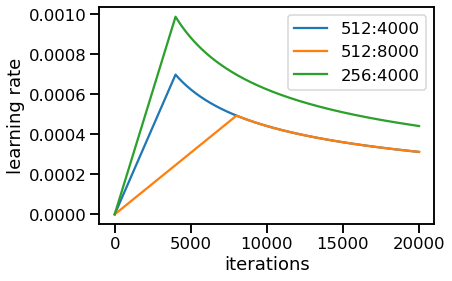

In [22]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), 
  [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.xlabel('iterations')
plt.ylabel('learning rate')

## 18. LabelSmoothing
下面进入有些难于理解的LabelSmoothing，简单思想就是劫富济贫。

这个方法虽然会损害Perplexity，但是会增加最后的BLEU score.

另外，这个名字不好，无论如何需要加上 KLLoss, 类似于：

LabelSmoothing -> LabelSmoothingKLLoss 其实是最终计算损失函数的。

In [23]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx # '<blank>' 的id
        self.confidence = 1.0 - smoothing # 自留的概率值、得分 e.g. 0.6
        self.smoothing = smoothing # 均分出去的概率值，得分 e.g. 0.4
        self.size = size # target vocab size 目标语言词表大小
        self.true_dist = None
        
    def forward(self, x, target):
        "in real-world case: 真实情况下"
        #  x的shape为(batch.size * seq.len, target.vocab.size)
        # y的shape是(batch.size * seq.len)
        
        # x=logits，(seq.len, target.vocab.size)
        # 每一行，代表一个位置的词
        # 类似于：假设seq.len=3, target.vocab.size=5
        # x中保存的是log(prob)
        #x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        # target 类似于：
        # target = tensor([2, 1, 0])，torch.size=(3)
        
        assert x.size(1) == self.size # 目标语言词表大小
        true_dist = x.data.clone()
        # true_dist = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        true_dist.fill_(self.smoothing / (self.size - 2))
        # true_dist = tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])
        
        # 注意，这里分母target.vocab.size-2是因为
        # (1) 最优值 0.6要占一个位置；
        # (2) 填充词 <blank> 要被排除在外
        # 所以被激活的目标语言词表大小就是self.size-2
        
        true_dist.scatter_(1, target.data.unsqueeze(1), 
          self.confidence)
        # target.data.unsqueeze(1) -> 
        # tensor([[2],
        #[1],
        #[0]]); shape=torch.Size([3, 1])  
        # self.confidence = 0.6
        
        # 根据target.data的指示，按照列优先(1)的原则，把0.6这个值
        # 填入true_dist: 因为target.data是2,1,0的内容，
        # 所以，0.6填入第0行的第2列（列号，行号都是0开始）
        # 0.6填入第1行的第1列
        # 0.6填入第2行的第0列：
        # true_dist = tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])
          
        true_dist[:, self.padding_idx] = 0
        # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
        # 设置true_dist这个tensor的第一列的值全为0
        # 因为这个是填充词'<blank>'所在的id位置，不应该计入
        # 目标词表。需要注意的是，true_dist的每一列，代表目标语言词表
        #中的一个词的id
        
        mask = torch.nonzero(target.data == self.padding_idx)
        # mask = tensor([[2]]), 也就是说，最后一个词 2,1,0中的0，
        # 因为是'<blank>'的id，所以通过上面的一步，把他们找出来
        
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            # 当target reference序列中有0这个'<blank>'的时候，则需要把
            # 这一行的值都清空。
            # 在一个batch里面的时候，可能两个序列长度不一，所以短的序列需要
            # pad '<blank>'来填充，所以会出现类似于(2,1,0)这样的情况
            # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
            # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
            # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
        self.true_dist = true_dist
        return self.criterion(x, 
          Variable(true_dist, requires_grad=False))
          # 这一步就是调用KL loss来计算
          # x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
          
          # true_dist=tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
          # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
          # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
          # 之间的loss了。细节可以参考我的那篇illustrated transformer

In [60]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

OSError: [E050] Can't find model 'de'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.